In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import random

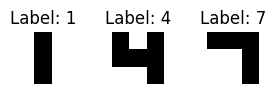

In [2]:
# first, define the base [3, 3] tensors representing the digits as a tuple with the label first

number_1 = torch.tensor([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
], dtype=torch.float)

number_4 = torch.tensor([
    [1, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
], dtype=torch.float)

number_7 = torch.tensor([
    [1, 1, 1],
    [0, 0, 1],
    [0, 0, 1],
], dtype=torch.float)

numbers = [(number_1, 1), (number_4, 4), (number_7, 7)]

# verify the digits are correct 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3, 1))
for i, ax in enumerate(axes.flatten()):
    img, label = numbers[i]
    ax.set_title(f"Label: {label}")
    ax.imshow(img, cmap='gray_r')  
    ax.axis('off')
plt.tight_layout()
plt.show()


In [16]:
# add random noise to each digit to construct dataset of 5000 1's, 5000 4's, and 5000 7's.
# There's no inherent issue with constraining the dataset to 5000 each - if we instead sampled uniformly, 
# the resulting dataset would have be within X with probablity Y anyway...
# What we do randomize is the variation in each sample 

DOWNSCALE = 0.175
NUM_SAMPLES = 5000

def addNoiseThenClip(tensor, n): 
    synthetic = torch.zeros((n, 3, 3))

    for i in range(n):
        noise = torch.randn(3, 3) * DOWNSCALE
        noisey_digit = tensor + noise
        noisey_digit = torch.clamp(noisey_digit, 0, 1)
        synthetic[i] = noisey_digit
    
    return synthetic

synthetic_1s = addNoiseThenClip(number_1, NUM_SAMPLES)
synthetic_4s = addNoiseThenClip(number_4, NUM_SAMPLES)
synthetic_7s = addNoiseThenClip(number_7, NUM_SAMPLES)

synthetic_dataset = torch.cat((synthetic_1s, synthetic_4s, synthetic_7s), dim=0)
synthetic_labels = [0]*NUM_SAMPLES + [1]*NUM_SAMPLES + [2]*NUM_SAMPLES

all_data = list(zip(synthetic_dataset, synthetic_labels))

print(all_data)

[(tensor([[0.0000, 0.9955, 0.0068],
        [0.0000, 0.9792, 0.1580],
        [0.0000, 1.0000, 0.0000]]), 0), (tensor([[0.0000, 1.0000, 0.1974],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.9805, 0.0000]]), 0), (tensor([[0.0000, 1.0000, 0.0000],
        [0.2274, 0.8560, 0.0000],
        [0.0000, 0.9383, 0.1553]]), 0), (tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0150, 0.8554, 0.0000]]), 0), (tensor([[0.0000, 1.0000, 0.1055],
        [0.0000, 0.9844, 0.0000],
        [0.2519, 1.0000, 0.0223]]), 0), (tensor([[0.1132, 1.0000, 0.0277],
        [0.0244, 1.0000, 0.0042],
        [0.0000, 1.0000, 0.2497]]), 0), (tensor([[0.0209, 0.9866, 0.1122],
        [0.0000, 0.9619, 0.2332],
        [0.0000, 0.9396, 0.0000]]), 0), (tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.1252],
        [0.3432, 0.9931, 0.0000]]), 0), (tensor([[0.0000, 0.8682, 0.1242],
        [0.0800, 0.6664, 0.0000],
        [0.0000, 1.0000, 0.0000]]), 0), (tensor([[0.0000, 

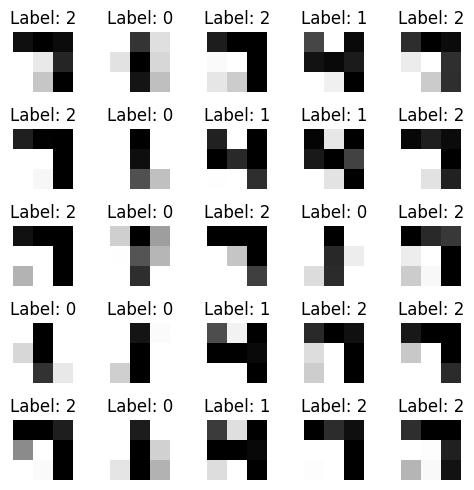

In [17]:
# verify the noisy digits are correct 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = random.choice(all_data)
    ax.set_title(f"Label: {label}")
    ax.imshow(img, cmap='gray_r')  
    ax.axis('off')
plt.tight_layout()
plt.show()


In [18]:
random.shuffle(all_data)
training = all_data[:12000]
testing = all_data[12000:]

In [19]:
#xplain so mf sharply
little_boi = torch.nn.Sequential(
    torch.nn.Linear(3*3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3)
)
opt = torch.optim.Adam(params=little_boi.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

losses = []

train_loader = torch.utils.data.DataLoader(training, batch_size=120, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing, batch_size=120, shuffle=True)

for epoch in range(50):
    for imgs, labels in train_loader:
        n = len(imgs)
        predictions = little_boi(imgs.view(n, -1))
        #print(predictions)
        loss = loss_func(predictions, labels)
        opt.zero_grad()
        loss.backward() 
        opt.step()
        losses.append(float(loss))
    print(f"Epoch {epoch}, Loss: {float(loss)}")

correct = 0
for images, labels in test_loader:
    data = images.view(n, -1)
    predictions = little_boi(data)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct += sum(predicted_classes.numpy() == labels.numpy())

print('Total Accuracy:', round(correct/3000, 5))

Epoch 0, Loss: 1.065916657447815
Epoch 1, Loss: 0.9006896615028381
Epoch 2, Loss: 0.7020609974861145
Epoch 3, Loss: 0.6154133081436157
Epoch 4, Loss: 0.4413335919380188
Epoch 5, Loss: 0.3382786214351654
Epoch 6, Loss: 0.2619791030883789
Epoch 7, Loss: 0.2231423556804657
Epoch 8, Loss: 0.19535531103610992
Epoch 9, Loss: 0.16311639547348022
Epoch 10, Loss: 0.1519751101732254
Epoch 11, Loss: 0.1288396716117859
Epoch 12, Loss: 0.11974113434553146
Epoch 13, Loss: 0.09171085804700851
Epoch 14, Loss: 0.08428899943828583
Epoch 15, Loss: 0.0786271020770073
Epoch 16, Loss: 0.07200442999601364
Epoch 17, Loss: 0.0686827078461647
Epoch 18, Loss: 0.05498142167925835
Epoch 19, Loss: 0.04806189239025116
Epoch 20, Loss: 0.04519588500261307
Epoch 21, Loss: 0.04229022189974785
Epoch 22, Loss: 0.039120979607105255
Epoch 23, Loss: 0.03879133611917496
Epoch 24, Loss: 0.03609135001897812
Epoch 25, Loss: 0.02583184279501438
Epoch 26, Loss: 0.03368479385972023
Epoch 27, Loss: 0.02435119077563286
Epoch 28, Loss

In [26]:
for param in little_boi.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader

SUBDIVISIONS = 50 # MAKE SURE THIS MATCHES BLENDER !!!

little_boi[2].weight.requires_grad = True
little_boi[2].bias.requires_grad = True

weight_values = torch.linspace(-1.5, 1.5, steps=SUBDIVISIONS)
bias_values = torch.linspace(-2.5, 2.5, steps=SUBDIVISIONS)

loader = DataLoader(training, shuffle=True, batch_size=1)

results = []
loss_func = nn.CrossEntropyLoss()

for weight_val in weight_values:
    for bias_val in bias_values:
        print(f"> training on: | {weight_val} | {bias_val}")
        with torch.no_grad():
            little_boi[2].weight[0, 0] = weight_val
            little_boi[2].bias[0] = bias_val

        total_loss = 0
        for data, target in loader:
            predicted = little_boi(data.view(len(data), -1))
            loss = loss_func(predicted, target)
            total_loss += loss.item()
            

        results.append((weight_val.item(), bias_val.item(), total_loss / len(loader)))


In [43]:
import pandas as pd

export = pd.DataFrame(columns = ['weight', 'bias', 'loss'], data = results)
export.to_csv('export_1')

In [51]:
for name, param in little_boi.state_dict().items():
    print(name, param)

0.weight tensor([[-0.4916,  0.7946, -0.5628, -0.2567,  0.8355, -0.4511,  0.5672,  0.9273,
         -0.5245],
        [ 0.3170,  1.7733,  0.6438, -1.6823, -1.6991,  0.3397,  0.1152, -0.3867,
          0.6257],
        [-0.6861,  0.9301, -0.7382,  0.0487,  0.4803, -0.6325,  0.7186,  0.7027,
         -0.6493]])
0.bias tensor([0.5398, 0.3861, 1.1184])
2.weight tensor([[ 1.3767, -0.9262,  1.4114],
        [-1.2955, -2.0132, -0.7531],
        [-0.3410,  1.5411, -0.4827]])
2.bias tensor([-2.1750,  2.3455, -2.0058])


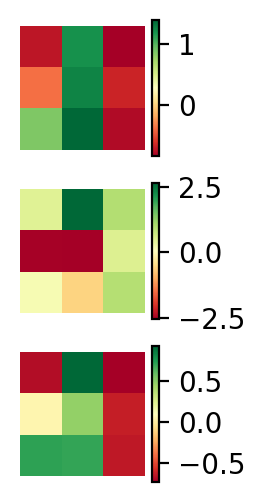

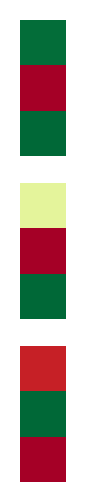

In [15]:
SCALE_DOWN = 1

neuron_1 = torch.tensor([[-0.4916,  0.7946, -0.5628], 
                         [-0.2567,  0.8355, -0.4511], 
                         [ 0.5672,  0.9273, -0.5245]]) * SCALE_DOWN

neuron_2 = torch.tensor([[0.3170,  1.7733,  0.6438], 
                         [-1.6823, -1.6991,  0.3397],  
                         [0.1152, -0.3867, 0.6257]]) * SCALE_DOWN

neuron_3 = torch.tensor([[-0.6861,  0.9301, -0.7382],  
                         [0.0487,  0.4803, -0.6325],  
                         [0.7186,  0.7027, -0.6493]])

output_1 = torch.tensor([[ 1.3767], [-0.9262],  [1.4114]])
output_4 = torch.tensor([[-1.2955], [-2.0132], [-0.7531]])
output_7 = torch.tensor([[-0.3410],  [1.5411], [-0.4827]]) * SCALE_DOWN

all_neurons = [neuron_1, neuron_2, neuron_3]

all_outputs = [output_1, output_4, output_7]

%config InlineBackend.figure_format = 'retina'


# verify the digits are correct 

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(1, 3))
for i, ax in enumerate(axes.flatten()):
    img = all_neurons[i]
    #ax.set_title(f"Neuron: {i}")
    im = ax.imshow(img, cmap='RdYlGn')  # green is very positive 
    ax.axis('off')
    plt.colorbar(im, ax=ax)
plt.savefig('neurons1.svg')
plt.show()



fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(1, 3))
for i, ax in enumerate(axes.flatten()):
    img = all_outputs[i]
    #ax.set_title(f"Output: {i}")
    ax.imshow(img, cmap='RdYlGn')  # green is very positive 
    ax.axis('off')
#plt.tight_layout()
plt.savefig('output1.svg')
plt.show()

In [25]:
# Doing a manual 'forward pass' using numpy and raw matrix multiplication
"""
A   B   C

|
|   |   |
|   |   |
|   |   |
|
"""

#example_1 = np.array()
example_4 = np.array([0.8573, 0.0000, 0.7576, 
                      0.9646, 1.0000, 0.7713, 
                      0.0000, 0.0000, 1.0000])
example_7 = np.array([1.0000, 0.9796, 1.0000,
                      0.3118, 0.2656, 0.9451,
                      0.0000, 0.0000, 0.8156])

import numpy as np

def ReLU(x):
    return np.maximum(x, 0)

def Softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

W_ba = np.array([
    [-0.4916,  0.7946, -0.5628, 
     -0.2567,  0.8355, -0.4511,  
     0.5672,  0.9273, -0.5245],

    [ 0.3170,  1.7733,  0.6438, 
     -1.6823, -1.6991,  0.3397,  
     0.1152, -0.3867, 0.6257],
     
    [-0.6861,  0.9301, -0.7382,  
     0.0487,  0.4803, -0.6325,  
     0.7186,  0.7027, -0.6493]
    ])

B_b = np.array([0.5398, 0.3861, 1.1184])

W_cb = np.array([
    [ 1.3767, -0.9262,  1.4114],
    [-1.2955, -2.0132, -0.7531],
    [-0.3410,  1.5411, -0.4827]
                 ])

B_c = np.array([-2.1750,  2.3455, -2.0058])




layer_a = ReLU(np.matmul(W_ba, example_7) + B_b)

#print(np.matmul(W_ba, example_4))
#print(np.matmul(W_ba, example_4)+B_b)

print('A', layer_a)

layer_b = Softmax(np.matmul(W_cb, layer_a) + B_c)

print('B', layer_b)


A [0.         2.93957397 0.        ]
B [5.96247477e-04 2.24360428e-03 9.97160148e-01]
